# 8.6 Практическая работа

Цель практической работы

Построить прототип рекомендательной системы с помощью подхода content-based и получать baseline.

## План ноутбука:

1. Вводные по задаче.

2. Библиотеки.

3. Блок функций.

4. Загрузка и просмотр данных.

5. Простая content-based system (на основе косинусного расстояния).

6. Подготовка агрегированных данных, tf-idf, обучение модели.

7. Подготовка данных, tf-idf, обучение модели.

8. Добавление описаний и tf-idf векторизация.

9. Применение SentenceTransformer преобразования.

10. Применение Word2Vec преобразования.

11. Результаты и выводы.

## 1. Вводные по задаче.

Данные лежат по адресу https://github.com/zygmuntz/goodbooks-10k.

1. Векторизовать названия книг и заменить фичи TF-IDF на альтернативные эмбеддинги текста, создать дополнительные признаки.

2. Построить модель многоклассовой классификации или регрессии, сделать выводы.

3. Получить описания книг с помощью библиотеки requests или поработать с JSON-файлами.

Задача 1

Для начала определитесь, к какой задаче ML вы сведёте нашу бизнес-задачу (построение рекомендательной системы) — к классификации или регрессии. Подумайте над метриками, которые вы хотите подсчитать, и в нескольких предложениях опишите, что вы выбрали и почему.

Далее прочитайте датасет и повторите предобработку, как во время скринкаста, но без шага создания TF-IDF-фич.

Задача 2

Используя любой из методов векторизации, постройте векторные представления заголовков книг, используйте их как фичи по аналогии с TF-IDF из видео. Сохраните полученные векторы в файл title_vecs.npy (позволяет более экономно хранить объекты из NumPy), чтобы их можно было использовать в дальнейшем.

Создайте описательный признак про пользователя и описательный признак про книги на основе данных, объясните, почему выбрали их.

Обучите модель машинного обучения (это может быть решающий лес, как в видео, либо выбранная вами модель), сделайте предикт на тесте и подсчитайте метрику. Сделайте вывод по метрике, хорошая ли получилась модель (в случае классификации можно сравнить с бейзлайном из видео). Можно ли пускать модель в продакшн?

Для случая классификации подсчитайте среднюю метрику Precision с помощью микроусреднения в случае классификации и RMSE в случае регрессии.

Задача 3

Давайте попробуем добавить ещё несколько признаков, основанных на тексте. Для этого вы можете воспользоваться либо готовым CSV-файлом, приложенным к заданию, либо, обращаясь к Google API, собрать свои расширенные данные.

Для этого вам надо пройтись по isbn в цикле и получить информацию по ссылке (f'https://www.googleapis.com/books/v1/volumes?q=isbn:{int(isbn)}')

Полученные данные обязательно сохраните в файл book_descr.csv.

Используя поле description из полученных данных, получите векторные представления описаний книг, используйте их как фичу и добавьте в модель. Сохраните полученные векторы в файл descr_vecs.npy.

Сравните, стали ли выбранные вами метрики лучше.

Критерии оценки

Принято: выполнены задачи, преодолён порог 0,4 по метрике Precision (усреднение micro по всем классам) в случае выбора классификации и <0,9 ошибка по RMSE в случае регрессии.

### Подготовительный этап (задача 1)

Выбор подхода к машинному обучению

Многоклассовая классификация

Обоснование:

    Позволяет предсказывать рейтинг книги

    Более интерпретируемые результаты

    Возможность использовать метрики классификации

Метрики оценки:

Precision (микроусреднение)

RMSE (для регрессионной части)

Accuracy


## 2. Библиотеки.

In [1]:
#!pip install fasttext
!pip install sentence_transformers
#!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
# нормализация и векторизация
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import requests
import json
# Сохранение в виде матрицы
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.io import mmwrite
from scipy.io import mmread

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.Блок функций.

In [4]:
# Просмотр данных


def check(obj):
    print('shape', obj.shape)
    print(obj.dtypes)
    print('пропуски', obj.isnull().sum())
    obj.dropna(inplace=True)
    print('после удаления пропусков', obj.shape)



def hist(obj):
    obj.hist( bins = 5 )




# Удаление ID-столбцов
def prepare_df(df):
    # Список столбцов для удаления
    id_columns = [
        col for col in df.columns
        if 'id' in col.lower() or
           col.endswith('_id') or
           col.startswith('id_')
    ]

    # Создание копии DataFrame без ID-столбцов
    recommendation_df = df.drop(columns=id_columns, errors='ignore')
    # Дополнительные шаги очистки
    clean_df = recommendation_df.drop_duplicates()
    clean_df = clean_df.dropna()


    return clean_df

### Функции Косинусное расстояние

In [5]:
## Косинусное расстояние

''' создание df

    Количество оцененных книг
    Средняя, медианная оценка
    Стандартное отклонение оценок

Создание признаков книги:

    Обработка словарей в столбцах
    Извлечение жанров
    Подсчет слов в названии
    Количество жанров
'''
def create_user_features(ratings):
    # Признаки пользователя
    user_features = ratings.groupby('user_id').agg({
        'book_id': 'count',  # Количество оцененных книг
        'rating': ['mean', 'median', 'std']  # Статистика оценок
    }).reset_index()

    user_features.columns = ['user_id', 'books_rated_count', 'avg_rating', 'median_rating', 'rating_std']
    return user_features

def create_item_features(books, genres_df):
    # Безопасная обработка словарей и строк
    def safe_extract_dict_features(value):
        try:
            # Если это словарь, возвращаем его ключи
            if isinstance(value, dict):
                return list(value.keys())
            # Если это строка, пытаемся распарсить как словарь
            elif isinstance(value, str):
                return list(eval(value).keys())
            # Если это список, возвращаем как есть
            elif isinstance(value, list):
                return value
            # Если пустое значение, возвращаем пустой список
            else:
                return []
        except:
            return []

    # Подготовка жанров с безопасным извлечением
    genres_series = genres_df.set_index('book_id')['genres'].apply(safe_extract_dict_features)

    # Признаки книги
    item_features = books[['book_id', 'title', 'average_rating', 'ratings_count']].copy()

    # Добавление жанров
    item_features['genres'] = item_features['book_id'].map(genres_series).fillna('').apply(list)

    # Извлечение названий
    item_features['title_words'] = item_features['title'].apply(
        lambda x: x.split() if isinstance(x, str) else []
    )

    # Дополнительные признаки
    item_features['genre_count'] = item_features['genres'].apply(len)
    item_features['title_word_count'] = item_features['title_words'].apply(len)

    return item_features

def create_cosinus_dataframe(ratings, user_features, item_features):
    # Создание оптимального DataFrame для рекомендательной системы
    recommendation_df = ratings.merge(user_features, on='user_id', how='left')
    recommendation_df = recommendation_df.merge(item_features, on='book_id', how='left')

    return recommendation_df

### Функции подготовки данных

In [6]:
## Нормализация текста

def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

# нормализация текста
#df_descr_prepared['title'] = df_descr_prepared['title'].map(lambda comments : text_cleaner(comments))

# Вариант 1: Преобразование списка в строку перед очисткой
def text_cleaner_safe(text):
    if isinstance(text, list):
        text = ' '.join(text)

    if not isinstance(text, str):
        return ''

    text = text.lower()
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)
    # Удаление специальных символов
    text = re.sub(r'[^a-zа-я\s]', '', text)
    return text.strip()

# Применение функции
#item_features['genres'] = item_features['genres'].apply(text_cleaner_safe)


# Вариант 2: Обработка списков
def process_genres(genres):
    if isinstance(genres, list):
        # Очистка каждого элемента списка
        cleaned_genres = [text_cleaner_safe(genre) for genre in genres]
        # Объединение в строку
        return ' '.join(cleaned_genres)
    elif isinstance(genres, str):
        return text_cleaner_safe(genres)
    return ''

#item_features['genres'] = item_features['genres'].apply(process_genres)

### Получение рекомендаций Косинус

In [7]:
'''

def get_recommendations(title, cosine_sim=cosine_sim, top_n=10):
    try:
        # Поиск книги с учетом регистра и частичного совпадения
        book_matches = df_books_with_genres[
            df_books_with_genres['title'].str.contains(title, case=False, na=False)
        ]

        if len(book_matches) == 0:
            # Поиск максимально близких названий
            closest_titles = df_books_with_genres['title'].str.contains(title, case=False)
            if closest_titles.sum() > 0:
                book_matches = df_books_with_genres[closest_titles]
            else:
                # Нечеткий поиск
                from difflib import get_close_matches
                possible_titles = get_close_matches(title, df_books_with_genres['title'], n=5)
                if possible_titles:
                    print(f"Возможно, вы имели в виду: {possible_titles}")
                    return None

        # Берем первое совпадение
        idx = book_matches.index[0]

        # Получаем пары (индекс, сходство) для всех книг с данной книгой
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Сортируем книги по сходству
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Берем top_n рекомендаций (исключая саму книгу)
        sim_scores = sim_scores[1:top_n+1]

        # Получаем индексы книг
        book_indices = [i[0] for i in sim_scores]

        # Возвращаем DataFrame с рекомендациями
        recommendations = df_books_with_genres.iloc[book_indices][['title', 'authors', 'average_rating']]
        recommendations['similarity_score'] = [i[1] for i in sim_scores]

        return recommendations

    except Exception as e:
        print(f"Ошибка при поиске рекомендаций: {e}")
        return None

# Пример использования
def recommend_books(title):
    recommendations = get_recommendations_2(title)
    if recommendations is not None:
        print(f"Рекомендации для книги '{title}':")
        print(recommendations)
    else:
        print("Не удалось найти рекомендации.")


'''

'\n\ndef get_recommendations(title, cosine_sim=cosine_sim, top_n=10):\n    try:\n        # Поиск книги с учетом регистра и частичного совпадения\n        book_matches = df_books_with_genres[\n            df_books_with_genres[\'title\'].str.contains(title, case=False, na=False)\n        ]\n\n        if len(book_matches) == 0:\n            # Поиск максимально близких названий\n            closest_titles = df_books_with_genres[\'title\'].str.contains(title, case=False)\n            if closest_titles.sum() > 0:\n                book_matches = df_books_with_genres[closest_titles]\n            else:\n                # Нечеткий поиск\n                from difflib import get_close_matches\n                possible_titles = get_close_matches(title, df_books_with_genres[\'title\'], n=5)\n                if possible_titles:\n                    print(f"Возможно, вы имели в виду: {possible_titles}")\n                    return None\n\n        # Берем первое совпадение\n        idx = book_matches.i

### Коллаборативная фильтрация.

In [8]:


# User-Based Collaborative Filtering (UBCF)
def ubcf_recommendations(user_item_matrix, user_id, n_recommendations=10):
    # Вычисление косинусного сходства между пользователями
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(
        user_similarity,
        index=user_item_matrix.index,
        columns=user_item_matrix.index
    )

    # Найти ближайших соседей
    user_neighbors = user_similarity_df.loc[user_id].sort_values(ascending=False)[1:6]

    # Получить рекомендации на основе оценок соседей
    user_unread_books = user_item_matrix.loc[user_id] == 0
    neighbor_recommendations = user_item_matrix.loc[user_neighbors.index, user_unread_books]

    # Взвешенное голосование
    weighted_recommendations = neighbor_recommendations.mul(user_neighbors, axis=0).sum() / user_neighbors.sum()

    return weighted_recommendations.nlargest(n_recommendations)



# Item-Based Collaborative Filtering (IBCF)
def ibcf_recommendations(user_item_matrix, user_id, n_recommendations=10):
    # Вычисление сходства между книгами
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(
        item_similarity,
        index=user_item_matrix.columns,
        columns=user_item_matrix.columns
    )

    # Получить оцененные пользователем книги
    user_rated_books = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0]

    # Найти похожие книги
    similar_books_scores = {}
    for book, rating in user_rated_books.items():
        similar_books = item_similarity_df[book].sort_values(ascending=False)[1:6]
        for sim_book, similarity in similar_books.items():
            if sim_book not in user_rated_books.index:
                similar_books_scores[sim_book] = similar_books_scores.get(sim_book, 0) + similarity * rating

    return pd.Series(similar_books_scores).nlargest(n_recommendations)



# Гибридный подход
def hybrid_recommendations(user_item_matrix, user_id, alpha=0.5, n_recommendations=10):
    ubcf_rec = ubcf_recommendations(user_item_matrix, user_id, n_recommendations)
    ibcf_rec = ibcf_recommendations(user_item_matrix, user_id, n_recommendations)

    # Взвешенное объединение рекомендаций
    hybrid_rec = alpha * ubcf_rec + (1 - alpha) * ibcf_rec
    return hybrid_rec.nlargest(n_recommendations)

### Подготовка данных.

In [9]:


def preprocess(genres_df, ratings, books):
    # Создание безопасной копии
    genres_df = genres_df.copy()

    # Фильтрация жанров по книгам
    genres_df = genres_df[genres_df.book_id.isin(books.goodreads_book_id)]

    # Безопасное переименование колонок
    genres_df = genres_df.rename(columns={'genres': 'genres_dict'})

    def simple_one_hot(genres_dict, genre):
        """Создание One-Hot энкодинга для жанра"""
        if isinstance(genres_dict, str):
            genres_dict = eval(genres_dict)
        return 1 if genre in genres_dict else 0

    # Получение уникальных жанров
    all_genres = set()
    for dict_genre in genres_df.genres_dict:
        try:
            if isinstance(dict_genre, str):
                dict_genre = eval(dict_genre)
            all_genres.update(dict_genre.keys())
        except Exception as e:
            print(f"Ошибка обработки жанра: {dict_genre}, {e}")

    # Инициализация столбцов жанров с использованием .loc
    for genre in all_genres:
        genres_df.loc[:, genre] = 0
        genres_df.loc[:, genre] = genres_df.apply(
            lambda df: simple_one_hot(df['genres_dict'], genre),
            axis=1
        )

    # Слияние с сохранением уникальных идентификаторов
    df = ratings.merge(
        books[['book_id', 'title', 'goodreads_book_id']],
        left_on='book_id',
        right_on='book_id',
        how='left'
    )

    df = df.merge(
        genres_df,
        left_on='goodreads_book_id',
        right_on='book_id',
        how='left',
        suffixes=('', '_genres')  # Предотвращение дублирования колонок
    )

    # Удаление дублирующихся колонок book_id
    df = df.drop(columns=[col for col in df.columns if col.endswith('_genres')])

    # Профили пользователей по жанрам
    users_profiles = df.groupby('user_id')[list(all_genres)].sum()
    users_profiles.columns = ['user_'+name for name in list(users_profiles)]

    # Переименование колонок жанров книг
    df.columns = [
        'book_'+item if item in all_genres else item
        for item in list(df)
    ]

    # Слияние с профилями пользователей
    df = df.merge(
        users_profiles,
        on='user_id',
        how='left'
    )
    # удаление словаря
    df = df.drop(['genres_dict'], axis=1)

    return df









def prepare_recommendation_dataframe(ratings, books, genres_df, tag, booktag):
    # Предварительная обработка жанров
    def normalize_genres(genres):
        # Если genres - словарь, извлекаем название
        if isinstance(genres, dict):
            return genres.get('name', 'Unknown')
        # Если уже строка, возвращаем как есть
        return str(genres) if genres is not None else 'Unknown'

    # 2. Базовый датафрейм с рейтингами
    df = ratings.merge(
        books[['book_id', 'title', 'authors', 'average_rating', 'goodreads_book_id']],
        on='book_id'
    )

    # 3. Добавление жанров
    df = df.merge(genres_df, on='book_id', how='left')

    # 4. Добавление тегов с проверкой столбцов
    book_tags = (
        booktag.merge(tag, on='tag_id')
        .groupby('goodreads_book_id')['tag_name']
        .apply(list)
        .reset_index()
    )

    # 5. Безопасное объединение с тегами
    df = df.merge(book_tags, on='goodreads_book_id', how='left')

    # 6. Очистка и подготовка
    df['genres'] = df['genres'].apply(normalize_genres)
    df['tag_name'] = df['tag_name'].fillna('[]')

    # Кодирование жанров с помощью LabelEncoder
    le_genres = LabelEncoder()
    df['genres_encoded'] = le_genres.fit_transform(df['genres'])

    # 7. Численные признаки
    df['user_rating_count'] = df.groupby('user_id')['book_id'].transform('count')
    df['book_popularity'] = df.groupby('book_id')['user_id'].transform('count')

    # 8. Отбор и сортировка признаков
    columns = [
        'user_id', 'book_id', 'goodreads_book_id',
        'title', 'authors',
        'rating', 'average_rating',
        'genres', 'genres_encoded', 'tag_name',
        'user_rating_count', 'book_popularity'
    ]

    return df[columns], le_genres


# Обратное преобразование
#original_genres = genre_encoder.inverse_transform(df_prepared['genres_encoded'])






def simple_one_hot(genre_dict, genre):
    if genre in genre_dict:
        return 1
    return 0



def process_genres(genres_df, books):
    # Создание копии DataFrame для безопасной модификации
    genres_df = genres_df.copy()

    # Фильтрация жанров по книгам
    genres_df = genres_df[genres_df.book_id.isin(books.goodreads_book_id)]

    # Получение уникальных жанров
    all_genres = set()
    for dict_genre in genres_df.genres:#_dict:
        try:
            # Безопасное преобразование, если genres_dict - строка
            if isinstance(dict_genre, str):
                dict_genre = eval(dict_genre)

            all_genres.update(dict_genre.keys())
        except Exception as e:
            print(f"Ошибка обработки жанра: {dict_genre}, {e}")

    # Инициализация столбцов жанров с использованием .loc
    for genre in all_genres:
        genres_df.loc[:, genre] = 0  # Использование .loc для безопасной установки значений


    return genres_df, all_genres

### Векторизация

In [10]:
def tfidf_vectorizer(train_df, column, unique_titles=True):
    if unique_titles:
        # Векторизация только уникальных названий
        titles = train_df[column].unique()
    else:
        # Векторизация всех названий в train_df
        titles = train_df[column]

    # Настройка TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=5000,  # Ограничение количества признаков
        stop_words='english',
        ngram_range=(1, 2)  # Учет отдельных слов и биграмм
    )

    # Обучение векторизатора
    vectorizer.fit(titles)

    return vectorizer




def vectorizer_feature(vectorizer, train_df, feature):

    # Размер чанка для обработки
    chunk_size = 100000  # например, 1000 строк за раз
    chunks = []
    # сбрасываем индексы
    train_df = train_df.reset_index(drop=True)
    # Обработка данных частями
    for start in range(0, len(train_df), chunk_size):
        end = min(start + chunk_size, len(train_df))
        chunk = train_df.iloc[start:end]

        # Преобразование заголовков в матрицу TF-IDF
        vectors = vectorizer.transform(chunk[feature])

        # Преобразование матрицы TF-IDF в DataFrame
        tfidf_df_chunk = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

        # Удаление исходных признаков и объединение с чанком
        chunk = chunk.drop([feature], axis=1)
        chunk.reset_index(drop=True, inplace=True)

        # Объединение с TF-IDF DataFrame
        combined_chunk = pd.concat([chunk, tfidf_df_chunk], axis=1)

        # Сохранение обработанного чанка
        chunks.append(combined_chunk)

    # Объединение всех чанков в один DataFrame
    train_df_processed = pd.concat(chunks, axis=0).reset_index(drop=True)

    # Проверка размера итогового DataFrame
    print(train_df_processed.shape)

    return train_df_processed

### Создание новых признаков

In [11]:
def create_advanced_features(df, books):
    # Копирование DataFrame для безопасной модификации
    df = df.copy()

    # 1. Статистические признаки пользователей
    user_stats = df.groupby('user_id').agg({
        'book_id': 'count',  # Количество прочитанных книг
    }).reset_index()
    user_stats.columns = ['user_id', 'user_total_books_read']

    df = df.merge(user_stats, on='user_id', how='left')

    # 2. Статистические признаки книг
    book_stats = df.groupby('book_id').agg({
        'user_id': 'count',  # Количество пользователей, прочитавших книгу
    }).reset_index()
    book_stats.columns = ['book_id', 'book_total_readers']

    df = df.merge(book_stats, on='book_id', how='left')

    # 3. Признаки из дополнительной информации о книгах
    if 'original_publication_year' in books.columns:
        df['book_publication_age'] = books['original_publication_year'].apply(
            lambda x: 2024 - x if pd.notnull(x) else -1
        )

    # 4. Признаки на основе авторов
    if 'authors' in books.columns:
        df['book_author_popularity'] = books.groupby('authors')['book_id'].transform('count')

    # 5. Признаки на основе рейтингов
    if 'average_rating' in books.columns:
        df['book_average_rating'] = df.merge(
            books[['book_id', 'average_rating']],
            on='book_id',
            how='left'
        )['average_rating']

    # 6. Энкодинг жанров
    genre_columns = [col for col in df.columns if col.startswith('book_') and col not in ['book_id', 'book_title']]

    # Создание признака разнообразия жанров
    df['user_genre_diversity'] = df[genre_columns].apply(lambda row: row.sum(), axis=1)

    ''' 7. Признаки взаимодействия
    interaction_features = [
        'user_total_books_read',
        'book_total_readers',
        'book_publication_age',
        'book_author_popularity',
        'book_average_rating',
        'user_genre_diversity'
    ] '''

    # Удаление исходных признаков
    columns_to_drop = ['goodreads_book_id', 'genres_dict']

    df = df.drop(columns=columns_to_drop, errors='ignore')

    return df

### Вывод метрик модели.

In [12]:

# Вывод метрик и confusion_matrix
def metrix(classifier,test_df, test_y):
    predictions = classifier.predict(test_df)
    prec = precision_score(test_y, predictions, average='micro')
    print(prec)
    cm = confusion_matrix(test_y, predictions, labels=classifier.classes_, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
    disp.plot()
    plt.show()

    return prec, disp



# вывод важности признаков
def importances(model):
    # Получение важности признаков
    importances = model.feature_importances_

    # Сортировка индексов по убыванию важности
    sorted_indices = np.argsort(importances)[::-1]

    # Вывод названий признаков и их важности
    for f in range(len(importances)):
        print("%2d) %-*s %f" % (
            f + 1,
            30,
            X.columns[sorted_indices[f]],
            importances[sorted_indices[f]]
            ))

## 4. Загрузка и просмотр данных.

In [13]:
ratings = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/ratings.csv' )
#tread = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/to_read.csv' )
books = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/books.csv' )

#tag = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/tags.csv' )
#booktag = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/book_tags.csv')
genres_df = pd.read_json('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/goodreads_book_genres_initial.json', lines=True) # описаня книг

In [14]:
description = pd.read_csv('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/book_descr.csv') # описаня книг

In [15]:
#ratings = pd.read_csv( 'data/ratings.csv' )
#tread = pd.read_csv( 'data/to_read.csv' )
#books = pd.read_csv( 'data/books.csv' )

#tag = pd.read_csv( 'data/tags.csv' )
#booktag = pd.read_csv( 'data/book_tags.csv')
#genres_df = pd.read_json('data/goodreads_book_genres_initial.json', lines=True)
#description = pd.read_csv( 'data/book_descr.csv')

### Просмотр данных и удаление пропусков.

ratings

shape (5976479, 3)
user_id    int64
book_id    int64
rating     int64
dtype: object
пропуски user_id    0
book_id    0
rating     0
dtype: int64
после удаления пропусков (5976479, 3)


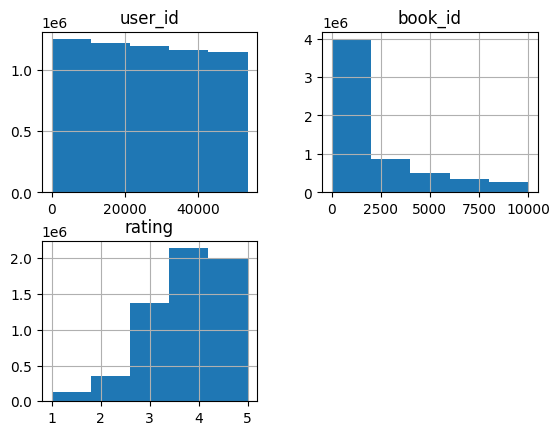

In [16]:
ratings = ratings.drop_duplicates(keep='first')
check(ratings)
hist(ratings)

tread

In [17]:
#check(tread)

books

In [18]:
books = books.drop_duplicates(keep='first')
check(books)

shape (10000, 23)
book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                         object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
image_url                     object
small_image_url               object
dtype: object
пропуски book_id                         0
goodreads_book_id               0
best_book_id                    0
work_i

tag

In [19]:
#check(tag)

In [20]:
#check(booktag)

genres_df

In [21]:
check(genres_df)

shape (2360655, 2)
book_id     int64
genres     object
dtype: object
пропуски book_id    0
genres     0
dtype: int64
после удаления пропусков (2360655, 2)


In [22]:
genres_df

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}
...,...,...
2360650,3084038,"{'non-fiction': 5, 'history, historical fictio..."
2360651,26168430,"{'mystery, thriller, crime': 4, 'children': 1,..."
2360652,2342551,"{'poetry': 14, 'children': 7, 'young-adult': 1..."
2360653,22017381,"{'romance': 13, 'mystery, thriller, crime': 2}"


In [23]:
check(description)

shape (10000, 3)
book_id        int64
descr         object
descr_vecs    object
dtype: object
пропуски book_id          0
descr         5107
descr_vecs       0
dtype: int64
после удаления пропусков (4893, 3)


## 5. Рекомендательная система на основе косинусного расстояния.

Этот подход основывается на характеристиках книг. Мы будем использовать такие атрибуты, как жанр и описание книги, чтобы рекомендовать похожие книги.

In [24]:
# Объединение df_books и df_genres по идентификатору книги
df_books_with_genres = books.merge(genres_df, on='book_id')

In [25]:
# Применение функции
df_books_with_genres['genres'] = df_books_with_genres['genres'].apply(text_cleaner_safe)

In [26]:
# Объединение названия и описания в одну строку для TF-IDF
df_books_with_genres['content'] = df_books_with_genres['title'] + ' ' + df_books_with_genres['genres']

In [27]:
df_books_with_genres

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,genres,content
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,,"The Hunger Games (The Hunger Games, #1)"
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,,"Twilight (Twilight, #1)"
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,,To Kill a Mockingbird
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,,The Great Gatsby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006,9988,129237,129237,1383130,44,674017722,9.780674e+12,John Rawls,1971.0,A Theory of Justice,...,168,234,607,2001,3171,3095,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,,A Theory of Justice
4007,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...,,"Bayou Moon (The Edge, #2)"
4008,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,,"Means of Ascent (The Years of Lyndon Johnson, ..."
4009,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...,,The Mauritius Command


In [28]:
# векторизация
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_books_with_genres['content'])

In [29]:
#Теперь вычислим косинусное сходство между книгами.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [30]:
def get_recommendations(title, cosine_sim=cosine_sim, top_n=10):
    try:
        # Поиск книги с учетом регистра и частичного совпадения
        book_matches = df_books_with_genres[
            df_books_with_genres['title'].str.contains(title, case=False, na=False)
        ]

        if len(book_matches) == 0:
            # Поиск максимально близких названий
            closest_titles = df_books_with_genres['title'].str.contains(title, case=False)
            if closest_titles.sum() > 0:
                book_matches = df_books_with_genres[closest_titles]
            else:
                # Нечеткий поиск
                from difflib import get_close_matches
                possible_titles = get_close_matches(title, df_books_with_genres['title'], n=5)
                if possible_titles:
                    print(f"Возможно, вы имели в виду: {possible_titles}")
                    return None

        # Берем первое совпадение
        idx = book_matches.index[0]

        # Получаем пары (индекс, сходство) для всех книг с данной книгой
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Сортируем книги по сходству
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Берем top_n рекомендаций (исключая саму книгу)
        sim_scores = sim_scores[1:top_n+1]

        # Получаем индексы книг
        book_indices = [i[0] for i in sim_scores]

        # Возвращаем DataFrame с рекомендациями
        recommendations = df_books_with_genres.iloc[book_indices][['title', 'authors', 'average_rating']]
        recommendations['similarity_score'] = [i[1] for i in sim_scores]

        return recommendations

    except Exception as e:
        print(f"Ошибка при поиске рекомендаций: {e}")
        return None


def recommend_books(title):
    recommendations = get_recommendations(title)
    if recommendations is not None:
        print(f"Рекомендации для книги '{title}':")
        print(recommendations)
    else:
        print("Не удалось найти рекомендации.")

In [31]:
recommended_books = get_recommendations('1984')
#print(recommended_books[['title', 'author']])
print(recommended_books)

                                               title  \
0            The Hunger Games (The Hunger Games, #1)   
1  Harry Potter and the Sorcerer's Stone (Harry P...   
2                            Twilight (Twilight, #1)   
3                              To Kill a Mockingbird   
4                                   The Great Gatsby   
5                             The Fault in Our Stars   
6                                         The Hobbit   
7                             The Catcher in the Rye   
8              Angels & Demons  (Robert Langdon, #1)   
9                                Pride and Prejudice   

                       authors  average_rating  similarity_score  
0              Suzanne Collins            4.34               0.0  
1  J.K. Rowling, Mary GrandPré            4.44               0.0  
2              Stephenie Meyer            3.57               0.0  
3                   Harper Lee            4.25               0.0  
4          F. Scott Fitzgerald            3.89  

In [32]:
#recommend_books("Война и мир")
recommend_books("1984")

Рекомендации для книги '1984':
                                               title  \
0            The Hunger Games (The Hunger Games, #1)   
1  Harry Potter and the Sorcerer's Stone (Harry P...   
2                            Twilight (Twilight, #1)   
3                              To Kill a Mockingbird   
4                                   The Great Gatsby   
5                             The Fault in Our Stars   
6                                         The Hobbit   
7                             The Catcher in the Rye   
8              Angels & Demons  (Robert Langdon, #1)   
9                                Pride and Prejudice   

                       authors  average_rating  similarity_score  
0              Suzanne Collins            4.34               0.0  
1  J.K. Rowling, Mary GrandPré            4.44               0.0  
2              Stephenie Meyer            3.57               0.0  
3                   Harper Lee            4.25               0.0  
4          F. Sco

## 6. Эксперимент обучения на агрегированных данных.

In [33]:
# Собираем полный большой df items + users
df = preprocess(genres_df, ratings, books)

In [34]:
# Добавляем новые признаки
# в функции применяется группировка, что сокращает количество данных
df = create_advanced_features(df, books)

In [35]:
# Удаляем все id, дубликаты и пропуски
df = prepare_df(df)

In [36]:
# Преобразование всех признаков в int8, кроме 'title'
for column in df.columns:
    if column != 'title':
        # Проверка на возможность преобразования
        if df[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Приведение к int8 с предварительным округлением и проверкой диапазона
            df[column] = df[column].clip(lower=-128, upper=127).astype('int8')

# Проверка результата
print(df.dtypes)

rating                                           int8
title                                          object
book_poetry                                      int8
book_children                                    int8
book_non-fiction                                 int8
book_mystery, thriller, crime                    int8
book_fantasy, paranormal                         int8
book_fiction                                     int8
book_romance                                     int8
book_comics, graphic                             int8
book_young-adult                                 int8
book_history, historical fiction, biography      int8
user_poetry                                      int8
user_children                                    int8
user_non-fiction                                 int8
user_mystery, thriller, crime                    int8
user_fantasy, paranormal                         int8
user_fiction                                     int8
user_romance                

In [37]:
X = df.drop(['rating'], axis=1)
y = df['rating']
train_df, test_df, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)
print(len(X))
print(len(y))

7164
7164


In [38]:
#train_df, test_df, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

In [39]:
# нормализация признака
train_df['title'] = train_df['title'].map(lambda comments : text_cleaner_safe(comments))

In [40]:
# нормализация признака
test_df['title'] = test_df['title'].map(lambda comments : text_cleaner_safe(comments))

In [41]:
# Векторизация названий книг
vectorizer_t = TfidfVectorizer(max_features=100, stop_words=stopwords.words('english'))

# Обучение на тренировочных данных
vectorizer_t.fit(train_df['title'])

TfidfVectorizer(max_features=100,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [42]:

# Векторизуем с разделением chunks
train_df = vectorizer_feature(vectorizer_t, train_df, 'title')

(5731, 126)


In [43]:
test_df = vectorizer_feature(vectorizer_t, test_df, 'title')

(1433, 126)


0.38241451500348916


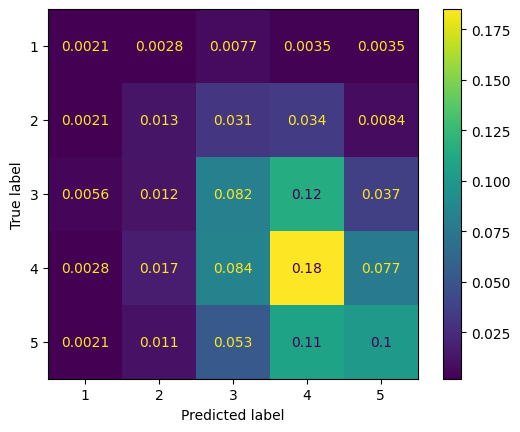

In [44]:
# RandomForest
classifier_agg = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42, n_jobs=-1)

classifier_agg.fit(train_df, train_y)

prec_agg, disp_agg = metrix(classifier_agg,test_df, test_y)

0.38241451500348916


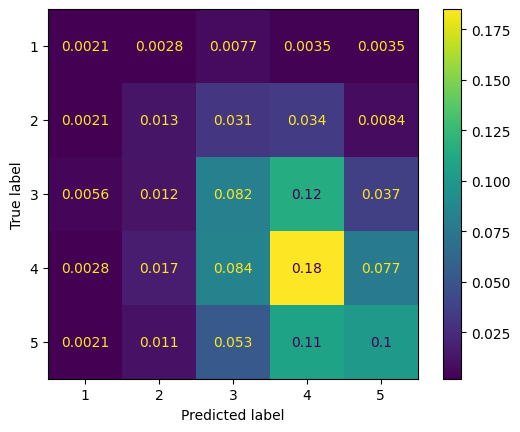

In [45]:
print(prec_agg)
disp_agg.plot()
plt.show()

## 7. Эксперимент на полных данных, обучение модели.

In [46]:
# Собираем полный большой df items + users
df = preprocess(genres_df, ratings, books)

In [47]:
# Удаляем все id, дубликаты и пропуски
df = prepare_df(df)

In [48]:
# Преобразование всех признаков в int8, кроме 'title'
for column in df.columns:
    if column != 'title':
        # Проверка на возможность преобразования
        if df[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Приведение к int8 с предварительным округлением и проверкой диапазона
            df[column] = df[column].clip(lower=-128, upper=127).astype('int8')

# Проверка результата
print(df.dtypes)

rating                                           int8
title                                          object
book_poetry                                      int8
book_children                                    int8
book_non-fiction                                 int8
book_mystery, thriller, crime                    int8
book_fantasy, paranormal                         int8
book_fiction                                     int8
book_romance                                     int8
book_comics, graphic                             int8
book_young-adult                                 int8
book_history, historical fiction, biography      int8
user_poetry                                      int8
user_children                                    int8
user_non-fiction                                 int8
user_mystery, thriller, crime                    int8
user_fantasy, paranormal                         int8
user_fiction                                     int8
user_romance                

In [49]:
# разделяем данные
X = df.drop(['rating'], axis=1)
y = df['rating']
train_df, test_df, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

In [50]:
# нормализация признака
train_df['title'] = train_df['title'].map(lambda comments : text_cleaner_safe(comments))

In [51]:
# нормализация признака
test_df['title'] = test_df['title'].map(lambda comments : text_cleaner_safe(comments))

In [52]:
# Векторизация названий книг
vectorizer_t = TfidfVectorizer(max_features=100, stop_words=stopwords.words('english'))

# Обучение на тренировочных данных
vectorizer_t.fit(train_df['title'])

TfidfVectorizer(max_features=100,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [53]:
# векторизация признака трейн
train_df = vectorizer_feature(vectorizer_t, train_df, 'title')

(4249074, 120)


In [54]:
# векторизация признака тест
test_df = vectorizer_feature(vectorizer_t, test_df, 'title')

(1062269, 120)


In [55]:
# Сохранение вектора в файл
#vector_to_save = vectorizer_t.transform(X['title'])

In [56]:
# Сохранение векторов
#np.save('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы//title_vecs.npy', vector_to_save)

In [57]:

# Обращаем df в разреженую матрицу
#sparse_train = sparse.csr_matrix(train_df.values)

In [58]:

# обращаем в матрицу
#sparse_test = sparse.csr_matrix(test_df.values)

0.45624507539992226


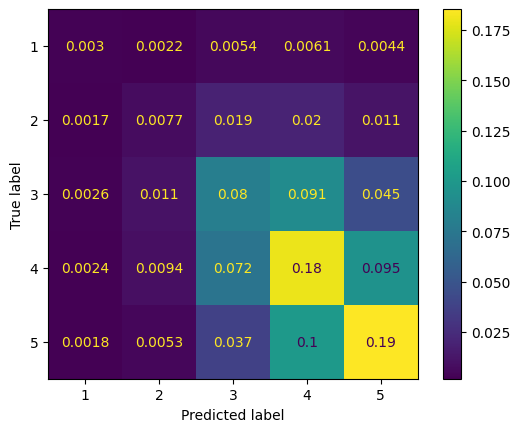

In [59]:
# Обучение модели и получение метрик# RandomForest
classifier_all = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42, n_jobs=-1)

classifier_all.fit(train_df, train_y)

prec_all, disp_all = metrix(classifier_all,test_df, test_y)

0.45624507539992226


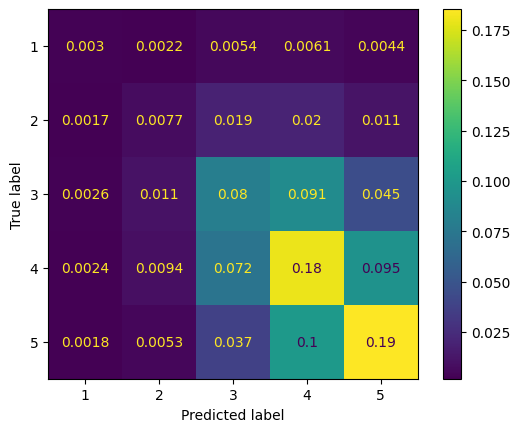

In [60]:
print(prec_all)
disp_all.plot()
plt.show()

## 8. Эксперемент обучения на полных данных с векторизацией описаний книг.

In [61]:
# Собираем полный большой df items + users
df = preprocess(genres_df, ratings, books)

In [62]:
# df items + users + description
df_descr = df.merge(description, on='book_id', how='inner')

In [63]:
df_descr.shape

(3413238, 27)

In [64]:
# Удаляем все id, дубликаты и пропуски
df_descr = prepare_df(df_descr)

In [65]:
df_descr.shape

(3150405, 24)

In [66]:
df = df_descr

In [67]:
# Преобразование всех признаков в int8, кроме 'title'
for column in df.columns:
    if column != 'title':
        # Проверка на возможность преобразования
        if df[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Приведение к int8 с предварительным округлением и проверкой диапазона
            df[column] = df[column].clip(lower=-128, upper=127).astype('int8')

# Проверка результата
print(df.dtypes)

rating                                           int8
title                                          object
book_poetry                                      int8
book_children                                    int8
book_non-fiction                                 int8
book_mystery, thriller, crime                    int8
book_fantasy, paranormal                         int8
book_fiction                                     int8
book_romance                                     int8
book_comics, graphic                             int8
book_young-adult                                 int8
book_history, historical fiction, biography      int8
user_poetry                                      int8
user_children                                    int8
user_non-fiction                                 int8
user_mystery, thriller, crime                    int8
user_fantasy, paranormal                         int8
user_fiction                                     int8
user_romance                

## Сохранение df

In [68]:
# вес df
df_memory_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Объем DataFrame: {df_memory_mb:.2f} MB")

Объем DataFrame: 8259.12 MB


In [69]:
#df.to_parquet('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/book_descr.parquet', compression='snappy')

In [70]:
#df.to_csv('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/book_descr.csv', index=False)

In [71]:
# Преобразование в разреженную матрицу
#sparse_matrix = csr_matrix(df)

In [72]:
# Сохранение матрицы
#mmwrite('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/book_descr.mtx', sparse_matrix)

In [73]:
# Загрузка разреженной матрицы
#loaded_sparse_matrix = mmread('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/book_descr.mtx')

In [74]:
# Преобразование в плотную матрицу и затем в DataFrame
#loaded_df = pd.DataFrame(loaded_sparse_matrix.toarray())

In [75]:
#del loaded_df

### Разделение данных.

In [76]:
X = df.drop(['rating', 'descr_vecs'], axis=1)
y = df['rating']
train_df, test_df, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)
print(len(X))
print(len(y))

3150405
3150405


### Векторизация заголовков и описаний книг.

In [77]:
df['title'].nunique()

4115

In [78]:
# нормализация признака
train_df['title'] = train_df['title'].map(lambda comments : text_cleaner_safe(comments))

In [79]:
# нормализация признака
test_df['title'] = test_df['title'].map(lambda comments : text_cleaner_safe(comments))

In [80]:
# Векторизация названий книг
vectorizer_t = TfidfVectorizer(max_features=100, stop_words=stopwords.words('english'))

# Обучение на тренировочных данных
vectorizer_t.fit(train_df['title'])

TfidfVectorizer(max_features=100,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [81]:
train_df = vectorizer_feature(vectorizer_t, train_df, 'title')

(2520324, 121)


In [82]:
test_df = vectorizer_feature(vectorizer_t, test_df, 'title')

(630081, 121)


In [83]:
# нормализация признака
# safe!
train_df['descr'] = train_df['descr'].apply(text_cleaner_safe)
train_df['descr'].nunique()

4008

In [84]:
test_df['descr'] = test_df['descr'].apply(text_cleaner_safe)

In [85]:
# Векторизация описаний книг
vectorizer_d = TfidfVectorizer(max_features=100, stop_words=stopwords.words('english'))

# Обучение на тренировочных данных
vectorizer_d.fit(train_df['descr'])

TfidfVectorizer(max_features=100,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [86]:
train_df = vectorizer_feature(vectorizer_d, train_df, 'descr')

(2520324, 220)


In [87]:
test_df = vectorizer_feature(vectorizer_d, test_df, 'descr')

(630081, 220)


In [88]:
df_memory_mb = train_df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Объем DataFrame: {df_memory_mb:.2f} MB")

Объем DataFrame: 3893.78 MB


In [89]:
#sparse_train = sparse.csr_matrix(train_df.values)

In [90]:
#sparse_test = sparse.csr_matrix(test_df.values)

In [91]:
#sparse.save_npz('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/train_matr.npz', sparse_train)

# Загрузка разреженной матрицы из файла
#loaded_sparse_matrix = #sparse.load_npz('sparse_matrix.np#z')

In [92]:
#sparse.save_npz('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/test_matr.npz', sparse_test)

# Загрузка разреженной матрицы из файла
#loaded_sparse_matrix = #sparse.load_npz('sparse_matrix.np#z')

## Сохранение векторов.

In [93]:
# Сохранение вектора в файл
vector_to_save = vectorizer_t.transform(X['title'])

In [94]:
# Сохранение векторов
np.save('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/title_vecs.npy', vector_to_save)

In [95]:
# Сохранение вектора в файл
vector_to_save_d = vectorizer_d.transform(X['descr'])

In [96]:
# Сохранение векторов
np.save('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/descr_vecs.npy', vector_to_save_d)

### Обучение модели.

0.38662172006456313


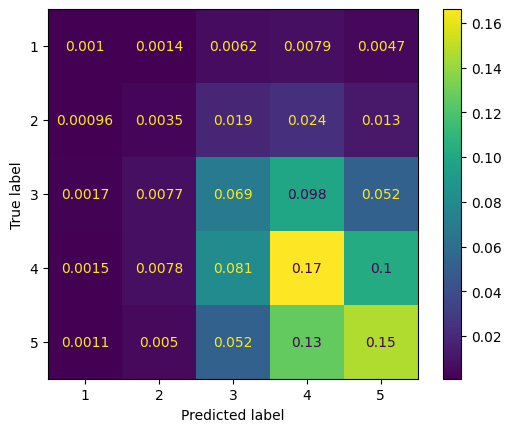

In [97]:
# RandomForest
classifier_full = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42, n_jobs=-1)

classifier_full.fit(train_df, train_y)

prec_full, disp_full = metrix(classifier_full,test_df, test_y)

0.38662172006456313


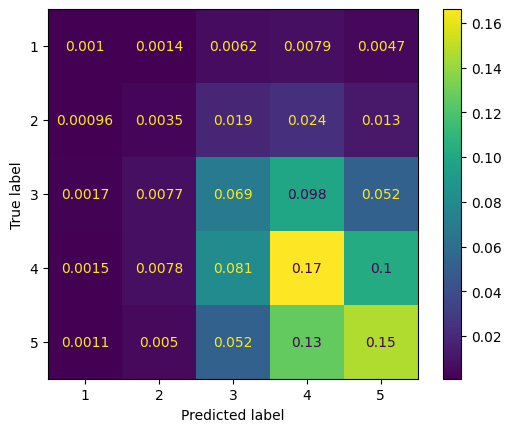

In [98]:
print(prec_full)
disp_full.plot()
plt.show()

## Альтернативные эмбеддинги для замены TF-IDF.

## 9. Sentence Transformers

Применяется аггрегированный df

In [99]:
#ratings = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/ratings.csv' )
#books = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/books.csv' )
#genres_df = pd.read_json('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/goodreads_book_genres_initial.json', lines=True) # описаня книг

# Создаем df
df = preprocess(genres_df, ratings, books)
#df = df.drop(['isbn', 'isbn13'], axis=1)

# в функции применяется группировка, что сокращает количество данных
df = create_advanced_features(df, books)

# Удаляем все id, дубликаты и пропуски
df = prepare_df(df)

# нормализация признака
df['title'] = df['title'].map(lambda comments : text_cleaner_safe(comments))

# Преобразование всех признаков в int8, кроме 'title'
for column in df.columns:
    if column != 'title':
        # Проверка на возможность преобразования
        if df[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Приведение к int8 с предварительным округлением и проверкой диапазона
            df[column] = df[column].clip(lower=-128, upper=127).astype('int8')

# Проверка результата
print(df.dtypes)

X = df.drop(['rating'], axis=1)
y = df['rating']
print(len(X))
print(len(y))

train_df, test_df, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

rating                                           int8
title                                          object
book_poetry                                      int8
book_children                                    int8
book_non-fiction                                 int8
book_mystery, thriller, crime                    int8
book_fantasy, paranormal                         int8
book_fiction                                     int8
book_romance                                     int8
book_comics, graphic                             int8
book_young-adult                                 int8
book_history, historical fiction, biography      int8
user_poetry                                      int8
user_children                                    int8
user_non-fiction                                 int8
user_mystery, thriller, crime                    int8
user_fantasy, paranormal                         int8
user_fiction                                     int8
user_romance                

In [100]:
# Загрузка предобученной модели
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [101]:
# Генерация эмбеддингов
def generate_embeddings(texts):
    embeddings = model.encode(texts)
    return embeddings

In [102]:
# Сброс индекса
train_df = train_df.reset_index(drop=True)

In [103]:
# Применение
title_embeddings = generate_embeddings(train_df['title'])

In [104]:
# Сброс индекса
test_df = test_df.reset_index(drop=True)

In [105]:
# Применение
title_embeddings_t = generate_embeddings(test_df['title'])

In [106]:
# Вариант С префиксом
emb_df_train = pd.DataFrame(
    title_embeddings,
    columns=[f'embedding_{i+1}' for i in range(title_embeddings.shape[1])])

In [107]:
# Объединение с исходным DataFrame
train_df = pd.concat([train_df, emb_df_train], axis=1)

# Удаление столбца 'title'
train_df.drop(columns=['title'], inplace=True)
train_df.shape

(5731, 410)

In [108]:
# Вариант С префиксом
emb_df_test = pd.DataFrame(
    title_embeddings_t,
    columns=[f'embedding_{i+1}' for i in range(title_embeddings_t.shape[1])])

# Объединение с исходным DataFrame
test_df = pd.concat([test_df, emb_df_test], axis=1)

# Удаление столбца 'title'
test_df.drop(columns=['title'], inplace=True)
test_df.shape

(1433, 410)

In [109]:
test_df.dtypes

,0
book_poetry,int8
book_children,int8
book_non-fiction,int8
"book_mystery, thriller, crime",int8
"book_fantasy, paranormal",int8
...,...
embedding_380,float32
embedding_381,float32
embedding_382,float32
embedding_383,float32


In [110]:
# RandomForestClassifier
classifier_sent = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42, n_jobs=-1)

In [111]:
classifier_sent.fit(train_df, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=-1,
                       random_state=42)

0.3286810886252617


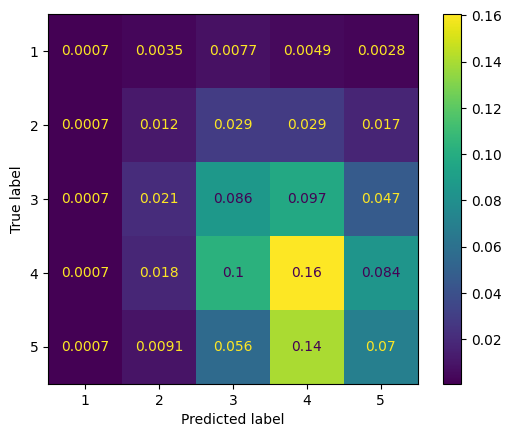

In [112]:
prec_sent, disp_sent = metrix(classifier_sent,test_df, test_y)

## 10. Word2Vec

Применяется аггрегированный df

In [113]:
#ratings = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/ratings.csv' )
#books = pd.read_csv( '/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/books.csv' )
#genres_df = pd.read_json('/content/drive/MyDrive/Scientist/Advanced/Рекомендательные системы/data/goodreads_book_genres_initial.json', lines=True) # описаня книг

# Создаем df
df = preprocess(genres_df, ratings, books)
#df = df.drop(['isbn', 'isbn13'], axis=1)

# в функции применяется группировка, что сокращает количество данных
df = create_advanced_features(df, books)

# Удаляем все id, дубликаты и пропуски
df = prepare_df(df)

# нормализация признака
df['title'] = df['title'].map(lambda comments : text_cleaner_safe(comments))

# Преобразование всех признаков в int8, кроме 'title'
for column in df.columns:
    if column != 'title':
        # Проверка на возможность преобразования
        if df[column].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Приведение к int8 с предварительным округлением и проверкой диапазона
            df[column] = df[column].clip(lower=-128, upper=127).astype('int8')

# Проверка результата
print(df.dtypes)

X = df.drop(['rating'], axis=1)
y = df['rating']
print(len(X))
print(len(y))

train_df, test_df, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

rating                                           int8
title                                          object
book_poetry                                      int8
book_children                                    int8
book_non-fiction                                 int8
book_mystery, thriller, crime                    int8
book_fantasy, paranormal                         int8
book_fiction                                     int8
book_romance                                     int8
book_comics, graphic                             int8
book_young-adult                                 int8
book_history, historical fiction, biography      int8
user_poetry                                      int8
user_children                                    int8
user_non-fiction                                 int8
user_mystery, thriller, crime                    int8
user_fantasy, paranormal                         int8
user_fiction                                     int8
user_romance                

In [114]:
def word2vec_embeddings(texts):
    # Предобработка текста
    tokenized_texts = [text.split() for text in texts]

    # Обучение модели
    model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5)

    # Усреднение эмбеддингов слов
    def text_to_embedding(text):
        words = text.split()
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(100)

    embeddings = np.array([text_to_embedding(text) for text in texts])
    return embeddings

w2v = word2vec_embeddings(train_df['title'])

In [115]:
w2v = word2vec_embeddings(train_df['title'])

In [116]:
w2v_t = word2vec_embeddings(test_df['title'])

In [117]:
# Сброс индексов
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [118]:
# Создание DataFrame с эмбеддингами
emb_df = pd.DataFrame(w2v, columns=[f'w2v_emb_{i}' for i in range(w2v.shape[1])])

# Конкатенация с исходным DataFrame
train_df = pd.concat([train_df, emb_df], axis=1)

# Удаление столбца 'title'
train_df.drop(columns=['title'], inplace=True)
train_df.shape

(5731, 126)

In [119]:
# Создание DataFrame с эмбеддингами
emb_df_t = pd.DataFrame(w2v_t, columns=[f'w2v_emb_{i}' for i in range(w2v_t.shape[1])])

# Конкатенация с исходным DataFrame
test_df = pd.concat([test_df, emb_df_t], axis=1)

# Удаление столбца 'title'
test_df.drop(columns=['title'], inplace=True)
test_df.shape

(1433, 126)

0.32937892533147245


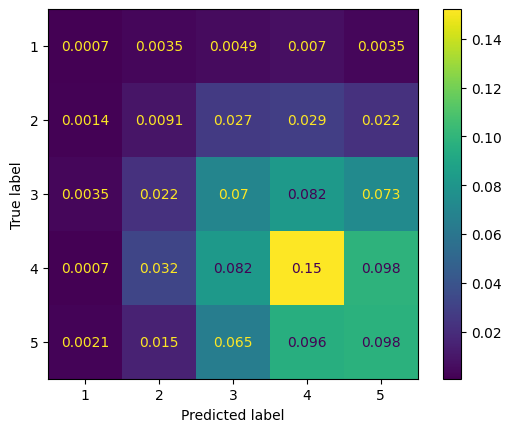

In [120]:
# RandomForestClassifier
classifier_w2v = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=42, n_jobs=-1)
classifier_w2v.fit(train_df, train_y)
prec_w2v, disp_w2v = metrix(classifier_w2v,test_df, test_y)

### Матрица TF-IDF дает лучшие результаты в данном эксперименте, почти на десять процентов. По сравнению с SentenceTransformer и word2vec.

## 11. Результаты и выводы.

Выбор подхода к машинному обучению

Многоклассовая классификация

Обоснование:

    Позволяет предсказывать рейтинг книги

    Более интерпретируемые результаты

    Возможность использовать метрики классификации

Метрики оценки:

Precision (микроусреднение)

### Во всех эксперементах применалась модель RandomForestClassifier  с идентичными параметрами.

### Метрики модели на данных с дополнительными признаками и TF-IDF векторизацией:

  Данные были агрегированы, что позволило значительно сократить размер данных и вычислительную нагрузку (подобная подготовка данных применяется в исследованиях Word2Vec и SentenceTransformer).

  Созданы новые признаки user и item.

  Применяется векторизация признака 'title' - TF-IDF.

  Метрика модели удовлетворяет поставленым условиям.

0.38241451500348916


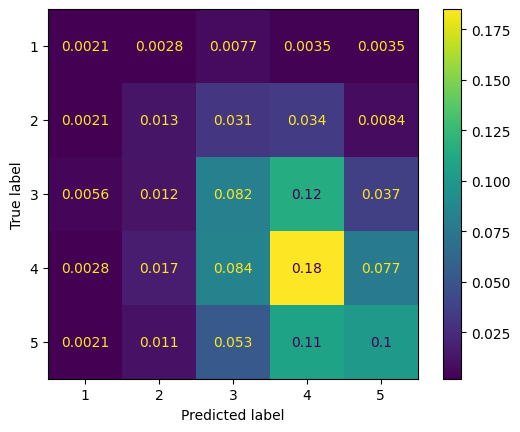

In [121]:
print(prec_agg)
disp_agg.plot()
plt.show()


### Метрики модели на данных с дополнительными признаками и SentenceTransformer преобразованием:

Данные были агрегированы, что позволило значительно сократить размер данных и вычислительную нагрузку (подобная подготовка данных применяется в исследованиях Word2Vec и SentenceTransformer).

Созданы новые признаки user и item.

Применяется векторизация признака 'title' - SentenceTransformer.

Метрика модели существенно снизилась по сравнению с подобными условиями и применением векторизации TF-IDF вместо SentenceTransformer. Разница во времени вычисления, на предоставленных данных незначительная.

0.3286810886252617


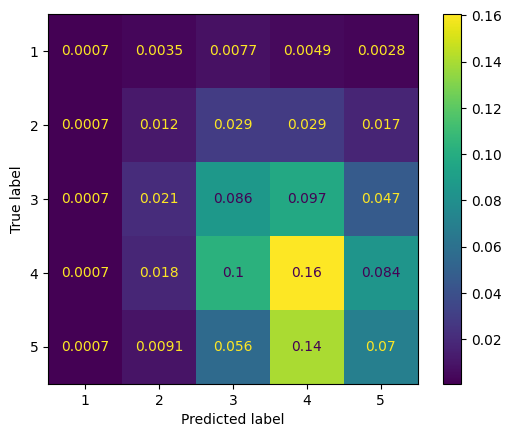

In [122]:
print(prec_sent)
disp_sent.plot()
plt.show()


### Метрики модели на данных с дополнительными признаками и Word2Vec преобразованием:

Данные были агрегированы, что позволило значительно сократить размер данных и вычислительную нагрузку (подобная подготовка данных применяется в исследованиях Word2Vec и SentenceTransformer).

Созданы новые признаки user и item.
Применяется векторизация признака 'title' - Word2Vec.

Метрика модели значительно снизилась по сравнению с подобными условиями и применением векторизации TF-IDF и SentenceTransformer. Однако время вычисления Word2Vec, на предоставленных данных по сравнению с TF-IDF и SentenceTransformer сократилось.

0.32937892533147245


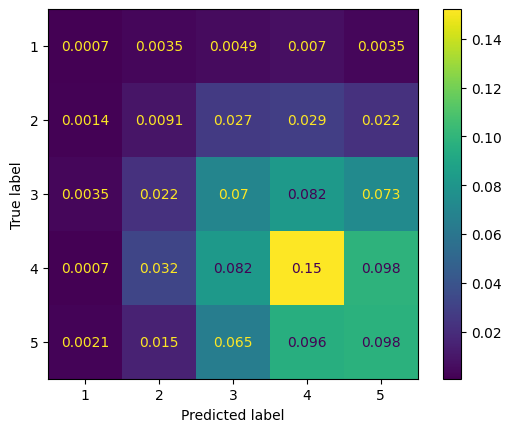

In [123]:
print(prec_w2v)
disp_w2v.plot()
plt.show()

### Метрики модели на полных, неагрегированных данных, с применением TF-IDF векторизации к признаку 'title'.

Подготовка и векторизация данных потребовала значительных вычислительных ресурсов. Однако метрики модели оказались наилучшими в проведенных эксперементах.

0.45624507539992226


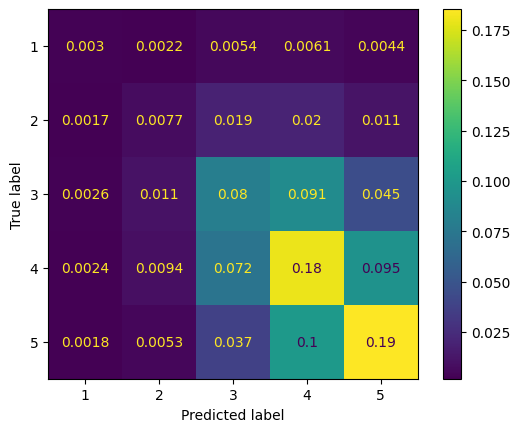

In [126]:
print(prec_all)
disp_all.plot()
plt.show()


Метрики модели на полных, неагрегированных данных, с применением TF-IDF векторизации к признакам 'title' и 'description'.
Подготовка и векторизация данных потребовала  самых значительных вычислительных ресурсов в проведенных эксперементах. Однако метрика модели значительно снизилась.

0.38662172006456313


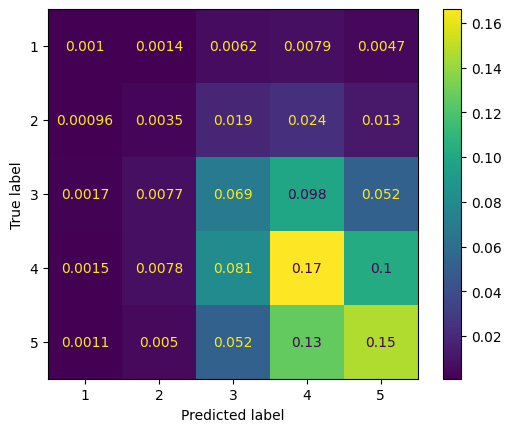

In [125]:
print(prec_full)
disp_full.plot()
plt.show()

### Итоги моделирования:

Лучшие метрики показали модели с применением TF-IDF векторизации признака 'title' на полных данных.

И применением TF-IDF векторизации признака 'title' на агрегированых данных.

И удовлетворяют поставленым условиям.

# Резюме



1. Можно ли полученую модель в prod?

a. В случае если еще нет никакой модели, однозначно да.

b. В случае если модели уже есть, имеет смысл протестировать количество переходов клиентов на рекомендации и время.

Почему: Поведения user зависит от множества факторв, в том числе которые не отслеживаются. А именно, например: физическое состояние, наличие времени, настроения, и так далее.

Таким образом user вчера хотел одно, завтра может захотеть другое, а сегодня он может и не знать чего на самаом деле хочет.

User существо многогранное, по этому расширение круга рекомендаций может дать положительный результат.

2. Мое видение решения задачи.

Недостаток / Решение

 Создание из небольших данных объемного df из признаков users и items

Мое видение: обучение двух моделей отдельно для признаков users и items, с последующим голосованием или обучением третьей модели. Данный подход может существенно сократить объем данных для обучения.

0.45624507539992226


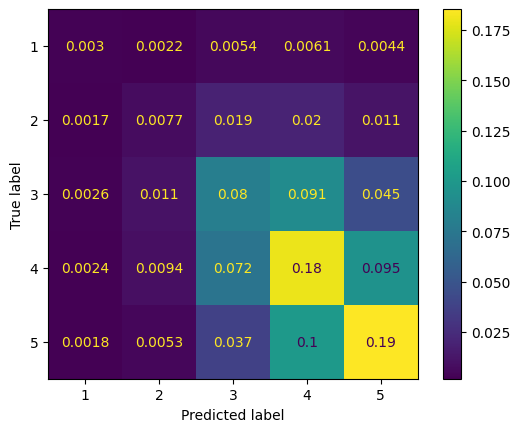

In [127]:
print(prec_all)
disp_all.plot()
plt.show()